# Topic Modeling with CorEx

In [3]:
import pickle

In [4]:
import re

In [5]:
import string

In [6]:
# Install CorEx 
# !pip install corextopic
# !pip install networkx

In [7]:
# Import other packages for examples
import pandas as pd
import numpy as np
import scipy.sparse as ss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [115]:
from sklearn.metrics import pairwise_distances

In [154]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_rows', 660)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.10f}'.format

## Load the data

In [8]:
df_zipped_post4_2019_sept_up_pickle = pickle.load(open("df_zipped_post4_2019_sept_up_2020-03-14_16PM.p", "rb"))

df_zipped_post4_2019_sept_up_pickle.shape

(8313, 15)

## Pre-process the data

Note that the default for CorEx is to use CountVectorizer with __binary=True__.

It has not been tested, so the makers of CorEx cannot vouch for it, but if you have large documents, it may be worth trying splitting into shorter documents, TF-IDF, binary=False, average binary bag of words, etc.

In [9]:
df_zipped_post = df_zipped_post4_2019_sept_up_pickle.copy()

In [408]:
df_zipped_post.shape

(8313, 15)

In [10]:
df_zipped_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8313 entries, 3818 to 0
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   post_id_container           8313 non-null   object        
 1   post_text                   8313 non-null   object        
 2   post_time                   8313 non-null   object        
 3   post_author                 8313 non-null   object        
 4   original_post_id_container  8313 non-null   object        
 5   topic_title                 8313 non-null   object        
 6   post_hour_min               8313 non-null   object        
 7   post_date                   8313 non-null   datetime64[ns]
 8   dow                         8313 non-null   int64         
 9   week                        8313 non-null   period[W-SUN] 
 10  week_alt                    8313 non-null   object        
 11  month                       8313 non-null   object      

In [11]:
df_zipped_post.describe()

,dow,Topic_Count
count,8313.000000,8313.000000
mean,2.872729,116.830386
std,1.932367,167.809010
min,0.000000,1.000000
25%,1.000000,14.000000
50%,3.000000,43.000000
75%,4.000000,128.000000
max,6.000000,594.000000


<AxesSubplot:xlabel='Topic_Count', ylabel='Count'>

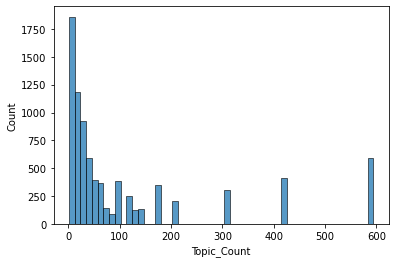

In [12]:
sns.histplot(data=df_zipped_post, x="Topic_Count")

### Make Adjustments to text

In [46]:
# Create text copy
df_zipped_post['post_text_original'] = df_zipped_post['post_text']

#### Testing

In [49]:
new_df = df_zipped_post.loc[:,['post_id_container','post_time','topic_title','post_text','post_text_original']].head(10)

In [50]:
new_df.shape

(10, 5)

#### Removing Responses

In [132]:
def remove_original_responses(df):
    df.post_text = df["post_text"].str.split('\n\n\n').str[-1]
    df.post_text = df["post_text"].str.replace('\n\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('...', '. ', regex=False)

#### Remove Specific Characters & Websites

In [13]:
no_at_symbol = lambda x: re.sub(r"@", ' ', x)
no_lb_symbol = lambda x: re.sub(r"#", ' ', x)
no_website = lambda x: re.sub(r"http\S+", '', x)

#### Remove Remaining Non-Alphanumeric and Standardize

In [14]:
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

#### Replace Named Groups

In [15]:
ssa_word_list = ['social security', 'socialsecurity']
ssa_word_list2 = [' ss ',' ssa ']
vba_word_list = ['vavetbenefits','veterans benefits administration', 
                 'veteranbenefitsadministration']
vba_word_list2 = [' vba ']
vha_word_list = ['veteranshealth','veterans health administration']
vha_word_list2 = [' vha ']
veteran_word_list = ['i am a veteran','iamaveteran', 'i am a vet','im a vet']
va_word_list = ['deptvetaffairs']
va_word_list2 = ['the va ']
bva_word_list = ['bva', 'board of veterans appeals', 'board of veteran appeals',"board of veterans' appeals"]
black_veterans = ['black veterans','black veteran','black vets','blackvets','blackveterans']
covid_list = ['covidpandemic','covid pandemic','covid','coronavirus','covid19','covid-19','covid 19','the pandemic','this pandemic', 'coronaviruspandemic', 'coronavirus pandemic']
vaccine_list = ['coronavirus_pandemicvaccine','covid19vaccine','covidvaccine','covid19 vaccine','covid-19 vaccine','covid19vaccination','covid vaccine','covid19 vaccine',
          'covid-19 vaccines','coronavirus_pandemic vaccine','coronavaccine', 'the vaccine']
greetings_list = ['good morning', 'good evening', 'greetings all']


In [16]:
SSA = lambda x: re.sub("|".join(sorted(ssa_word_list, key = len, reverse = True)), 
                       'Social_Security', x)

In [17]:
SSA2 = lambda x: re.sub("|".join(sorted(ssa_word_list2, key = len, reverse = True)), 
                       ' Social_Security ', x)

In [18]:
VBA = lambda x: re.sub("|".join(sorted(vba_word_list, key = len, reverse = True)), 
                       'Veterans_Benefits_Admin', x)

In [19]:
VBA2 = lambda x: re.sub("|".join(sorted(vba_word_list2, key = len, reverse = True)), 
                       ' Veterans_Benefits_Admin ', x)

In [20]:
VHA = lambda x: re.sub("|".join(sorted(vha_word_list, key = len, reverse = True)), 
                       'Veterans_Health_Admin', x)

In [21]:
VHA2 = lambda x: re.sub("|".join(sorted(vha_word_list2, key = len, reverse = True)), 
                       ' Veterans_Health_Admin ', x)

In [22]:
veteran_words = lambda x: re.sub("|".join(sorted(veteran_word_list, key = len, reverse = True)), 
                       'i_am_a_veteran', x)

In [23]:
va_words = lambda x: re.sub("|".join(sorted(va_word_list, key = len, reverse = True)), 
                       'department_of_va', x)

In [24]:
va_words2 = lambda x: re.sub("|".join(sorted(va_word_list2, key = len, reverse = True)), 
                       'department_of_va ', x)

In [25]:
bva_words = lambda x: re.sub("|".join(sorted(bva_word_list, key = len, reverse = True)), 
                       'board_veterans_appeals', x)

In [26]:
black_veterans_words = lambda x: re.sub("|".join(sorted(black_veterans, key = len, reverse = True)), 
                       'black_veterans', x)

In [27]:
covid_words = lambda x: re.sub("|".join(sorted(covid_list, key = len, reverse = True)), 
                       'coronaviruspandemic', x)

In [28]:
vaccine_words = lambda x: re.sub("|".join(sorted(vaccine_list, key = len, reverse = True)), 
                       'coronaviruspandemic vaccine', x)

In [29]:
greetings = lambda x: re.sub("|".join(sorted(greetings_list, key = len, reverse = True)), 
                       'good_morning_evening', x) 

In [30]:
dont = lambda x: re.sub("|".join(sorted(greetings_list, key = len, reverse = True)), 
                       'good_morning_evening', x)  

#### Remove Emojis

In [31]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [32]:
remove_emoji('patience🤦‍ Veterans_Benefitsssss_Admin 🙏depar🙏tment_of_va Veterans_Health_Admin')
#emoji("Hi, I am Emoji  😜")

'patience Veterans_Benefitsssss_Admin department_of_va Veterans_Health_Admin'

#### Create Checking Tool

In [33]:
def update_base_table_for_CorEx(df):
    
    # Pre-process data
    df.drop_duplicates(subset='post_text',inplace=True)
    
    # Create copy of original post
    df['post_text_original'] = df['post_text']
    
    # Remove responses
    df.post_text = df["post_text"].str.split('\n\n\n').str[-1]
    df.post_text = df["post_text"].str.replace('\n\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('...', '. ', regex=False)
    df.post_text = df["post_text"].str.replace('\t', ' ', regex=False) 
    df.post_text = df["post_text"].str.replace('↑', ' ', regex=False)
    
    # Mirror Tweet adjustments
    df['post_text'] = df.post_text.map(no_at_symbol)    # replace with a ' ', vs the rest of the replaces which will replace with ''
    df['post_text'] = df.post_text.map(no_lb_symbol)    # replace with a ' ', vs the rest of the replaces which will replace with ''
    df['post_text'] = df.post_text.map(punc_lower)
    df['post_text'] = df.post_text.map(no_website)
    df['post_text'] = df.post_text.map(SSA).map(SSA2).map(VBA).map(VBA2).map(VHA).map(VHA2).map(veteran_words).map(va_words).map(va_words2)
    df['post_text'] = df.post_text.map(black_veterans_words)
    df['post_text'] = df.post_text.map(covid_words) 
    df['post_text'] = df.post_text.map(vaccine_words) 
    df['post_text'] = df.post_text.map(bva_words)
    df['post_text'] = df.post_text.map(greetings)
    df['post_text'] = df.post_text.map(alphanumeric)
    df['post_text'] = df.post_text.apply(remove_emoji)
    #df.post_text = df.post_text.map(no_rt_marker)        
    
    return df

## Check Final DF

In [243]:
list_of_elements = ['post_content1452399',   
'post_content1503177',   
'post_content1505696',   
'post_content1507547',   
'post_content1507915',   
'post_content1510979']  

In [264]:
#contain_values = df_zipped_post2[df_zipped_post2['post_text'].str.contains('wasgionce wrote')]
#print (contain_values)
#df_zipped_post2.loc[df_zipped_post2['post_id_container'].isin(list_of_elements)]

In [34]:
df_zipped_post2 = update_base_table_for_CorEx(df_zipped_post)

In [35]:
df_zipped_post2.shape

(7589, 16)

In [37]:
df_zipped_post2.loc[:,['post_id_container','post_time','topic_title','post_text']].head(5)

,post_id_container,post_time,topic_title,post_text
3818,post_content1418166,"12:27 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from App...,cue please explain
3819,post_content1418167,"12:34 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from App...,the original ptsd claim is on appeal the atto...
3820,post_content1418168,"12:44 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from App...,if service connection is on appeal that is all...
3821,post_content1418686,"6:50 PM - Sep 04, 2019",Legacy Appeals; Actual number of days from App...,went to see the lung specialist today he is a ...
3822,post_content1418699,"7:43 PM - Sep 04, 2019",Legacy Appeals; Actual number of days from App...,did he review your military medical records an...


In [265]:
#df_zipped_post2.loc[8197,['post_id_container','post_time','topic_title','post_text','post_text_original']]

In [305]:
contain_values = df_zipped_post2[df_zipped_post2['post_text'].str.contains('vaccine')]
print (contain_values)

         post_id_container  \
12138  post_content1467998   
12139  post_content1468083   
2214   post_content1499175   
2219   post_content1499251   
2221   post_content1499485   
2225   post_content1499495   
2226   post_content1499496   
2228   post_content1499500   
2229   post_content1499501   
2232   post_content1499510   
2233   post_content1499525   
2234   post_content1499543   
2236   post_content1499607   
2237   post_content1499614   
2238   post_content1499619   
2239   post_content1499646   
2240   post_content1499653   
2242   post_content1499667   
2245   post_content1499683   
2247   post_content1499692   
2248   post_content1499699   
2250   post_content1499711   
2251   post_content1499822   
2252   post_content1499948   
2254   post_content1499951   
2255   post_content1501086   
2256   post_content1501112   
2258   post_content1501177   
2259   post_content1501178   
2262   post_content1501328   
2263   post_content1501329   
2264   post_content1501345   
2265   pos

In [403]:
df_zipped_post2.shape

(7589, 26)

## Vectorize

In [38]:
from sklearn.feature_extraction import text 

In [39]:
additional_stop_words = ['rt','vets','vet','veteran','veterans']
additional_stop_words2 = ['rt','vets','vet','veteran','veterans','Veterans_Benefits_Admin','veterans_benefits_admin', 'veterans_health_admin',
                          'Veterans_Health_Admin','department_of_va','veteransbenefitsadmin departmentofva', 
                          'veteransbenefitsadmin departmentofva veterans_health_adminadminadminadminadmin', 
                          'departmentofva veterans_health_adminadminadminadminadmin', 'veteransbenefitsadmin', 
                          'veterans_health_adminadminadminadminadmin', 'departmentofva','va','cnn', 'foxnews','msnbc','nbc','abc','fox', 'tapatalk',
                          'just','know','said','dont','did','like','think','told', 'sent', 'using', 'wrote', 'pm', 'feb', 'good_morning_evening']

stop_wordz = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
stop_wordz2 = text.ENGLISH_STOP_WORDS.union(additional_stop_words2)

In [78]:
vectorizer = CountVectorizer(#max_features=20000,
                             stop_words=stop_wordz2, token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

In [81]:
vectorizer_ngram2 = CountVectorizer(#max_features=20000,
                             stop_words=stop_wordz2, ngram_range=(2,2), token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

In [82]:
doc_word = vectorizer.fit_transform(df_zipped_post2.post_text)
words = list(np.asarray(vectorizer.get_feature_names()))

In [83]:
doc_word_ngram2 = vectorizer_ngram2.fit_transform(df_zipped_post2.post_text)
words_ngram2 = list(np.asarray(vectorizer_ngram2.get_feature_names()))

In [80]:
print(doc_word[:5])

  (0, 3660)	1
  (0, 5422)	1
  (1, 10385)	1
  (1, 11742)	1
  (1, 2701)	1
  (1, 771)	1
  (1, 1090)	2
  (1, 13514)	1
  (1, 1176)	2
  (1, 12111)	1
  (1, 6927)	1
  (1, 14250)	1
  (2, 2701)	1
  (2, 771)	3
  (2, 13359)	2
  (2, 3194)	2
  (2, 3873)	1
  (2, 1004)	1
  (2, 10845)	2
  (2, 12001)	1
  (2, 4140)	1
  (2, 10846)	1
  (2, 6569)	1
  (2, 12283)	1
  (2, 10204)	1
  :	:
  (3, 10561)	1
  (3, 7515)	1
  (3, 3915)	1
  (3, 1876)	1
  (3, 10005)	1
  (3, 7878)	1
  (3, 10359)	1
  (3, 2337)	1
  (3, 13070)	1
  (3, 11570)	1
  (3, 6451)	1
  (3, 4279)	1
  (3, 12712)	1
  (3, 3877)	1
  (3, 7173)	1
  (3, 5618)	1
  (3, 1330)	1
  (3, 15905)	1
  (3, 6812)	1
  (4, 13359)	1
  (4, 12654)	1
  (4, 9358)	1
  (4, 9177)	2
  (4, 12155)	2
  (4, 11283)	1


In [84]:
doc_word.shape

(7589, 17120)

In [378]:
words_ngram2[3000:3500]

['aid track',
 'aidand attendance',
 'aidandattendance rates',
 'aidassistance time',
 'aide kicked',
 'aides years',
 'aids approximately',
 'aids apps',
 'aids bluetooth',
 'aids boy',
 'aids case',
 'aids combine',
 'aids connect',
 'aids does',
 'aids hearing',
 'aids hoping',
 'aids locates',
 'aids make',
 'aids need',
 'aids otitis',
 'aids ptot',
 'aids range',
 'aids rated',
 'aids receive',
 'aids red',
 'aids smart',
 'aids sure',
 'aids tested',
 'aids todaygonna',
 'aids use',
 'aids wood',
 'aids years',
 'ailment befalls',
 'ailments access',
 'ailments case',
 'ailments great',
 'ailments let',
 'ailments straight',
 'aim thought',
 'aimed prostate',
 'ain doubt',
 'ain fish',
 'ain light',
 'ain supposed',
 'aint asking',
 'aint billy',
 'aint bubba',
 'aint business',
 'aint buying',
 'aint current',
 'aint cute',
 'aint cutehes',
 'aint easy',
 'aint giving',
 'aint going',
 'aint gon',
 'aint gonna',
 'aint got',
 'aint heart',
 'aint job',
 'aint making',
 'aint me

In [394]:
docs = df_zipped_post2.post_text

In [395]:
type(docs)

pandas.core.series.Series

In [397]:
doc_1 = 'Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter'
doc_2 = 'Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way.'
doc_3 = 'In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.'
docs2 = [doc_1, doc_2, doc_3]
type(docs2)

list

In [417]:
from collections import Counter
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stop_wordz2

# doc_1 = 'Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter'
# doc_2 = 'Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way.'
# doc_3 = 'In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.'
docs = df_zipped_post2.post_text.tolist() 
docs = (' '.join(filter(None, docs))).lower()

tokens = word_tokenize(docs)
tokens = [t for t in tokens if t not in stop_words]
word_l = WordNetLemmatizer()
tokens = [word_l.lemmatize(t) for t in tokens if t.isalpha()]

bi_grams = list(ngrams(tokens, 2)) 
counter = Counter(bi_grams)
counter.most_common(5)

[(('service', 'connected'), 289),
 (('cp', 'exam'), 223),
 (('effective', 'date'), 194),
 (('service', 'connection'), 186),
 (('don', 't'), 181)]

In [399]:
counter.most_common(20)

[(('sent', 'using'), 1103),
 (('wrote', 'pm'), 703),
 (('pm', 'feb'), 378),
 (('wrote', 'feb'), 373),
 (('sent', 'iphone'), 343),
 (('iphone', 'using'), 343),
 (('service', 'connected'), 289),
 (('cp', 'exam'), 223),
 (('effective', 'date'), 194),
 (('service', 'connection'), 186),
 (('don', 't'), 181),
 (('pm', 'day'), 179),
 (('coronaviruspandemic', 'vaccine'), 170),
 (('medical', 'record'), 164),
 (('good', 'morning'), 160),
 (('year', 'ago'), 148),
 (('feb', 'wrote'), 148),
 (('sent', 'ipad'), 146),
 (('ipad', 'using'), 146),
 (('pm', 'jan'), 140)]

In [393]:
sorted_items

[(26038, 1)]

In [357]:
df_zipped_post.loc[:,['post_id_container','post_time','topic_title','post_text','post_text_original']].head(10)

,post_id_container,post_time,topic_title,post_text,post_text_original
3818,post_content1418166,"12:27 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from Appeal Certification,cue please explain,CUE? Please explain
3819,post_content1418167,"12:34 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from Appeal Certification,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"No way to say for certain how long it will take for a hearing. I am out of Cleveland and I have been waiting since 2017 for a hearing on an appeal I have. \n\nIf this was denied and only service connection is on appeal, the appeal will not provide a percentage. \n\nWhat exactly is on appeal? This denial was reopened, denied again and now appealed? Who told you that you were being awarded 70%?\n\n\nThe original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!"
3820,post_content1418168,"12:44 PM - Sep 02, 2019",Legacy Appeals; Actual number of days from Appeal Certification,if service connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"teamgatorupdates wrote:\nNo way to say for certain how long it will take for a hearing. I am out of Cleveland and I have been waiting since 2017 for a hearing on an appeal I have. \n\nIf this was denied and only service connection is on appeal, the appeal will not provide a percentage. \n\nWhat exactly is on appeal? This denial was reopened, denied again and now appealed? Who told you that you were being awarded 70%?\n\n\nThe original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!\n\n\nIf service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal.\n\nRaters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned.\n\nIf this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one."
3821,post_content1418686,"6:50 PM - Sep 04, 2019",Legacy Appeals; Actual number of days from Appeal Certification,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"Went to see the lung specialist today...he is a triple Board Certified MD and has provided new evidence of accidental injury from left chest tube, causing Intercostal Nerve Damage resulting in chronic chest pain, inability to take deep breaths at normal intervals. He has ordered up a CAT scan and whatever evidence is produced is going directly to the Board. As of right now, no decision has been made on my Appeal. It is my hope that the Board will find in my favor based on new evidence from today. Will update here if anything happens."
3822,post_content1418699,"7:43 PM - Sep 04, 2019",Legacy Appeals; Actual number of days from Appeal Certification,did he review your military medical records and post service medical records,

In [358]:
len(words)

17123

# CorEx

In [85]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model_standard = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model_standard.fit(doc_word, words=words, docs=df_zipped_post2.post_text)

### Topics

In [86]:
# Print all topics from the CorEx topic model
topics_standard = topic_model_standard.get_topics()
for n,topic in enumerate(topics_standard):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: claim,rating,decision,service,evidence,letter,exam,cp,disability,appeal
1: time,years,cruiser,does,make,say,im,new,work,people
2: medical,health,records,doctor,care,opinion,coronaviruspandemic,going,need,want
3: plan,released,index,feel,heard,medicare,fund,arriving,baseline,coming
4: program,home,used,went,year,life,daily,getting,wife,worth
5: morning,snow,cold,house,winter,south,weather,good,beautiful,power
6: event,thank,sc,showed,concern,perform,picked,apparently,checked,csp
7: got,old,story,man,navy,hard,came,young,turn,kind
8: blood,test,left,pain,week,stay,big,outside,bad,implant
9: called,office,local,phone,mail,calling,allow,set,advice,computer


### Top documents associated with a topic

In [87]:
# Let's check out topic : graphics
for i in list(range (10)):
    print("Topic Model: {}".format(i))
    print(topic_model_standard.get_top_docs(topic=i, n_docs=3))
    print('+++++++++++++++++++++++++++++++++++++++')

Topic Model: 0
[('do a google search for “spinal stenosis and ihd” or “spinal stenosis and parkinson’s disease” or “spinal stenosis and diabetics type ” \xa0and then tell me that there is no connection between agent orange and spinal stenosis and degenerative disk disease \xa0study after study after study show a significant cause and effect relationship between degenerative bone conditions and the conditions department_of_va recognizes as presumptive to agent orange \xa0i have diagnosed ddd \xa0i have diagnosed spinal stenosis \xa0i had a hip replacement because of ddd and arthritic degeneration of my hip and upper femur \xa0i also am service connected for pd and ihd i guess the results of being sprayed directly twice by ranch hand didn’t help much \xa0nor did spending   months out of the   months i was in vietnam was within  miles of the dmz in the very northern part of i corps help me avoid the worse effects of agent orange since this was the heaviest sprayed portion of the entire co

### CorEx Document Placement

Use the .labels attribute to find the topic labels associated with each document that you trained on.

Use the .predict() method to predict labels based on a __new doc_word__

In [88]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model_standard.predict(doc_word), columns=['topic'+str(i) for i in range(10)])
predictions.head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,True,False,True,True
4,False,False,False,False,False,False,False,False,False,False


In [130]:
doc_topic_array = topic_model_standard.p_y_given_x

In [89]:
predictions_nums = pd.DataFrame(topic_model_standard.p_y_given_x, columns=['topic'+str(i) for i in range(10)])

In [118]:
predictions_nums.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.000048,0.000004,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.001291
1,0.999859,0.000020,0.000006,0.000024,0.000029,0.000134,0.000190,0.007256,0.000404,0.001292
2,0.999999,0.000010,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.017055
3,0.999999,0.002085,0.008184,0.000189,0.999999,0.095016,0.999999,0.000198,0.999999,0.999982
4,0.001645,0.000001,0.001870,0.000024,0.000252,0.000134,0.000190,0.000192,0.000404,0.001292


In [73]:
predictions.shape

(7589, 10)

### Determine Number of Topics

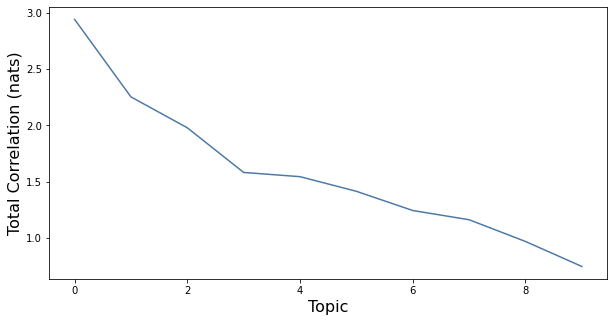

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(topic_model_standard.tcs.shape[0]), topic_model_standard.tcs, color='#4e79a7')#, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

### Join Original Table with Topic Assignments

In [98]:
df_zipped_post2.drop(df_zipped_post2.columns[[16,17,18,19,20,21,22,23,24,25]], axis = 1, inplace = True)

In [177]:
df_zipped_post2.shape

(7589, 16)

In [99]:
df_zipped_post3 = df_zipped_post2.copy()

In [101]:
df_zipped_post3 = df_zipped_post3.reset_index()

In [102]:
df_zipped_post3 = df_zipped_post3.join(pd.DataFrame(predictions_nums))

In [104]:
df_zipped_post3.shape

(7589, 27)

In [110]:
df_zipped_post3.rename(columns={"index": "original_index"}, inplace = True)

In [113]:
df_zipped_post3.head(5)

,original_index,post_id_container,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,...,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,3818,post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from App...,12:27:00,2019-09-02,0,...,0.000048,0.000004,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.001291
1,3819,post_content1418167,the original ptsd claim is on appeal the atto...,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from App...,12:34:00,2019-09-02,0,...,0.999859,0.000020,0.000006,0.000024,0.000029,0.000134,0.000190,0.007256,0.000404,0.001292
2,3820,post_content1418168,if service connection is on appeal that is all...,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from App...,12:44:00,2019-09-02,0,...,0.999999,0.000010,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.017055
3,3821,post_content1418686,went to see the lung specialist today he is a ...,"6:50 PM - Sep 04, 2019","[""POST_AUTHOR"", ""Indy_CV62_OS""]",post_content1511221,Legacy Appeals; Actual number of days from App...,18:50:00,2019-09-04,2,...,0.999999,0.002085,0.008184,0.000189,0.999999,0.095016,0.999999,0.000198,0.999999,0.999982
4,3822,post_content1418699,did he review your military medical records an...,"7:43 PM - Sep 04, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from App...,19:43:00,2019-09-04,2,...,0.001645,0.000001,0.001870,0.000024,0.000252,0.000134,0.000190,0.000192,0.000404,0.001292


In [112]:
pickle.dump(df_zipped_post3, open("df_zipped_post2_CorEx_Standard_v03.p", "wb" ) )

### Calculate Distance

In [122]:
df_predictions_nums = pd.DataFrame(predictions_nums)

In [124]:
predictions_nums

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.000048,0.000004,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.001291
1,0.999859,0.000020,0.000006,0.000024,0.000029,0.000134,0.000190,0.007256,0.000404,0.001292
2,0.999999,0.000010,0.000006,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.017055
3,0.999999,0.002085,0.008184,0.000189,0.999999,0.095016,0.999999,0.000198,0.999999,0.999982
4,0.001645,0.000001,0.001870,0.000024,0.000252,0.000134,0.000190,0.000192,0.000404,0.001292
...,...,...,...,...,...,...,...,...,...,...
7584,0.999999,0.999999,0.999999,0.000024,0.901291,0.013808,0.109331,0.000193,0.018431,0.999999
7585,0.000001,0.000001,0.000001,0.000024,0.000029,0.000134,0.000190,0.000192,0.000404,0.001291
7586,0.000010,0.000001,0.000028,0.000024,0.001042,0.000134,0.000190,0.002985,0.000415,0.001292
7587,0.000005,0.000006,0.999999,0.000024,0.000327,0.983501,0.000193,0.002969,0.022816,0.001315


In [128]:
print(pairwise_distances(predictions_nums,predictions_nums,metric='cosine'))

[[1.11022302e-16 9.63042762e-01 9.49359116e-01 ... 4.78806303e-01
  9.23336270e-01 8.01491792e-01]
 [9.63042762e-01 0.00000000e+00 1.49146316e-04 ... 9.90208194e-01
  9.99875181e-01 9.99605910e-01]
 [9.49359116e-01 1.49146316e-04 0.00000000e+00 ... 9.90420078e-01
  9.99875294e-01 9.98798542e-01]
 ...
 [4.78806303e-01 9.90208194e-01 9.90420078e-01 ... 0.00000000e+00
  9.62829849e-01 9.11661275e-01]
 [9.23336270e-01 9.99875181e-01 9.99875294e-01 ... 9.62829849e-01
  0.00000000e+00 9.78313930e-01]
 [8.01491792e-01 9.99605910e-01 9.98798542e-01 ... 9.11661275e-01
  9.78313930e-01 2.22044605e-16]]


In [138]:
#doc_topic_array
pairwise_distances(doc_topic_array[7588].reshape(1,-1),doc_topic_array,metric='cosine')

array([[8.01491792e-01, 9.99605910e-01, 9.98798542e-01, ...,
        9.11661275e-01, 9.78313930e-01, 2.22044605e-16]])

In [139]:
pairwise_distances(doc_topic_array[7588].reshape(1,-1),doc_topic_array,metric='cosine').argsort()

array([[7588, 5403, 7014, ..., 4554, 1225, 2779]])

In [ ]:
# Why would output above not have 0s in the relationship????

In [135]:
pairwise_distances(doc_topic_array[1].reshape(1,-1),doc_topic_array,metric='cosine')

array([[9.63042762e-01, 0.00000000e+00, 1.49146316e-04, ...,
        9.90208194e-01, 9.99875181e-01, 9.99605910e-01]])

In [136]:
pairwise_distances(doc_topic_array[1].reshape(1,-1),doc_topic_array,metric='cosine').argsort()

array([[   1, 4366, 5680, ..., 1087, 2153,  363]])

In [144]:
pairwise_distances(doc_topic_array.reshape(1,-1),doc_topic_array,metric='cosine')

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 75890 while Y.shape[1] == 10

### Make a Search Engine

In [165]:
t = ['i would straight up tell her that if she does not stop the harassment then you will no longer expose yourself to her bs']

In [166]:
#update_base_table_for_CorEx

In [167]:
vt = vectorizer.transform(t)

In [168]:
vt

<1x17120 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [169]:
tt = topic_model_standard.transform(vt)

In [170]:
pairwise_distances(tt,doc_topic_array,metric='cosine').argsort()[0:5]

array([[ 569, 1934, 7405, ..., 1033, 6022, 7357]])

In [171]:
df_zipped_post3.loc[[569,1934,7405],['post_text']]

,post_text
569,sent from my iphone using tapatalk you got willie petes gallons of and a flamethrower to keep the fire going there
1934,what about va on clamont rd in atlantaga
7405,ob i want either all beef or johnsonville sausage and steamed buns sent from my using tapatalk


In [172]:
a = 'sent from my iphone using tapatalk you got willie petes gallons of and a flamethrower to keep the fire going there'

In [175]:
a=re.sub('sent.*tapatalk','',a,flags=re.DOTALL)

In [176]:
a

' you got willie petes gallons of and a flamethrower to keep the fire going there'

# CorEx With Anchor Words (Low Strength)  *REVISIT*

In [337]:
topic_model_low_strength = ct.Corex(n_hidden=10, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model_low_strength.fit(doc_word, words=words, docs=df_zipped_post2.post_text, 
                anchors=[['coronaviruspandemic','vaccine'], 
                         ['disability'], 
                         ['cancer'], 
                         ['suicide', 'mental'],
                        ['tinnitus'],
                        ['orange','bluewater']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics_low_strength = topic_model_low_strength.get_topics()
for n,topic in enumerate(topics_low_strength):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: coronaviruspandemic,vaccine,people,got,shot,wife,home,getting,week,state
1: claim,disability,rating,decision,service,evidence,letter,cruiser,exam,based
2: cancer,future,scheduled,prostate,replacement,meaning,bladder,reduced,meds,training
3: mental,medical,need,opinion,doctor,help,care,health,treatment,questions
4: know,just,said,years,time,dont,did,like,think,going
5: orange,agent,index,artery,reminding,wall,farm,bathing,price,drop
6: wrote,feb,pm,jan,days,nov,oct,dec,skidrider,thats
7: long,way,day,house,really,life,little,times,old,took
8: year,school,college,high,drive,area,navy,iphone,recently,helped
9: cold,snow,weather,power,winter,south,stay,safe,rain,peace


# CorEx With Anchor Words (High Strength) *REVISIT*

In [325]:
topic_model = ct.Corex(n_hidden=10, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_zipped_post2.post_text, 
                anchors=[['coronaviruspandemic','vaccine'], 
                         ['disability'], 
                         ['cancer'], 
                         ['suicide', 'mental'],
                        ['tinnitus'],
                        ['orange','bluewater']
                        ['ptsd']], anchor_strength=4)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: coronaviruspandemic,vaccine,shot,got,wife,home,doing,shots,state,week
1: disability,claim,rating,decision,service,evidence,letter,cruiser,medical,based
2: cancer,future,scheduled,prostate,meaning,reduced,bladder,replacement,constant,meds
3: mental,need,care,health,help,want,doctor,treatment,thing,questions
4: know,just,said,tinnitus,years,did,dont,think,told,going
5: orange,agent,artery,index,reminding,wall,farm,drop,price,flood
6: wrote,feb,pm,jan,days,nov,dec,oct,appeals,thats
7: time,like,long,day,year,way,life,getting,use,used
8: drive,left,lower,door,lack,vietnam,maintenance,setting,helped,familiar
9: cold,snow,power,weather,winter,south,beautiful,peace,rain,land


# Types of Benefits *REVISIT*

In [327]:
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_zipped_post2.post_text, 
                anchors=[['benefits','benefit'], ['benefits','benefit'], ['benefits','benefit'], ['benefits','benefit']], anchor_strength=4)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: benefits,service,medical,rating,benefit,disability,cruiser,condition,records,based
1: benefits,benefit,know,said,just,time,dont,like,think,going
2: benefits,claim,decision,benefit,evidence,letter,appeal,claims,exam,file
3: benefits,benefit,years,state,story,took,times,place,away,money
4: coronaviruspandemic,got,vaccine,house,shot,wife,live,home,yesterday,shots
5: wrote,pm,days,day,ago,feb,week,life,couple,called
6: cold,winter,snow,peace,weather,beautiful,degrees,land,rain,warm
7: program,care,assessment,caregiver,hold,caregivers,secure,primary,federal,luck
